In [1]:
"""
Training file: Train a NN to map from simulation(intermediate) to experiments
Mapping Sim -> Exp (Supp Fig x)

General workflow: 
1) Load train data- input and output are latent images from pre-trained Stable Diffusion VAE
2) Define NN model 
3) Run the training and save the model weights
4) Plot the training and validation performance 


"""

'\nTraining file: Train a NN to map from simulation(intermediate) to experiments\nMapping Sim -> Exp (Supp Fig x)\n\nGeneral workflow: \n1) Load train data- input and output are latent images from pre-trained Stable Diffusion VAE\n2) Define NN model \n3) Run the training and save the model weights\n4) Plot the training and validation performance \n\n\n'

In [7]:
# import libraries 

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pickle
import json
from pytorch_msssim import ssim
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
"""
Loading desired output datset- simulated patterns (latent embeddings of this)
"""

foldername='/hpc/group/youlab/ks723/miniconda3/Lingchong/Latents'
latentname_input='latent_dim_SimcorrtoExp_images_40900_4channels_4x32x32_07092024.pickle'
latentname_output='latent_dim_Exp_images_40900_BnW_4channels_4x32x32_07092024.pickle'

filename_input=os.path.join(foldername,latentname_input)
filename_output=os.path.join(foldername,latentname_output)

pickle_in=open(filename_input,"rb")
yprime_in=pickle.load(pickle_in)
yprime_in=yprime_in[:30000,:,:,:]
yprime_in=torch.Tensor(yprime_in)
yprime_in=yprime_in.float()

pickle_out=open(filename_output,"rb")
yprime_out=pickle.load(pickle_out)
yprime_out=yprime_out[:30000,:,:,:]
yprime_out=torch.Tensor(yprime_out)
yprime_out=yprime_out.float()


In [4]:
"""
Defining dataset 
"""

# Define train and test datasets
dataset = torch.utils.data.TensorDataset(yprime_in, yprime_out)

# Split dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size=64
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)


In [5]:
"""
Defining NN model (Here: dilResNet)
"""

# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
currentSecond= datetime.now().second
currentMinute = datetime.now().minute
currentHour = datetime.now().hour

currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year



num_epochs = 500       
warmup_epochs=10
lr = 5e-4               #for fine tuning.
min_lr = 5e-6
gamma = 0.99

train_losses=[]
test_losses=[]

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print(f"Total Parameters in Neural Network: {count_parameters(model)}")


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
criterion = nn.MSELoss()

# Initialize lists to store individual and combined losses
train_losses = []
test_losses = []


# Training parameters and early stopping initialization
best_loss = float('inf')
epochs_without_improvement = 0
patience = 30  # Note: Initially set to 30
delta = 0.05 

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_params, batch_latents in train_loader:

            
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device
        inputs = batch_params.to(device)
        targets = batch_latents.squeeze(1).to(device)  # Adjust as per your data dimensions
    
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss 
        loss = criterion(outputs,targets)
        
        # Backward pass
        loss.backward()
        
        # Warm-up schedule: Adjust learning rate during initial epochs
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * (epoch + 1) / warmup_epochs
        
        # Optimizer step
        optimizer.step()
        
        # Accumulate losses for averaging
        running_loss += loss.item()
        
    
    # Scheduler step after warmup
    if epoch >= warmup_epochs:
        scheduler.step()
    # Ensure learning rate doesn't go below min_lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)
    
    # Validation loop for testing set
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_params, batch_latents in test_loader:
            # Move data to device
            inputs = batch_params.to(device)
            targets = batch_latents.squeeze(1).to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute combined loss and individual components
            loss = criterion(outputs, targets)
            
            # Accumulate validation losses
            val_loss += loss.item()
          
    
    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    
    # Store losses in respective lists
    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    
    # Determine logging interval
    interval = 2 if epoch < 20 else 40
    
    # Print loss information at specified intervals or at the last epoch
    if (epoch + 1) % interval == 0 or epoch + 1 == num_epochs:
        print(f"Epoch [{epoch + 1}/{num_epochs}] | "
              f"Train Total Loss: {avg_train_loss:.6f} | "
              f"Test Total Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.7f}")
    
    # Early stopping logic with tolerance
   
    if avg_val_loss < best_loss - delta:
        # Significant improvement
        best_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Significant improvement observed. "
              f"Best Validation Loss updated to {best_loss:.6f}.")
    elif avg_val_loss <= best_loss + delta:
        # Within tolerance
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Validation loss increased but within tolerance ({delta}). "
              f"Continuing training.")
    else:
        # Exceeded tolerance
        epochs_without_improvement += 1
        print(f"Epoch {epoch + 1}: Validation loss increased beyond tolerance. "
              f"Epochs without improvement: {epochs_without_improvement}/{patience}.")
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break


NAME =f"Pixel_32x32x4to32x32x4_dilRESNET_BnW_30k_SimtoExp_Model_v{currentMonth}{currentDay}_Cluster_GPU_tfData-{int(time.time())}"  # change this later to incorporate exact date 
torch.save(model.state_dict(), f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt')

cuda
Total Parameters in Neural Network: 2224196
Epoch 1: Significant improvement observed. Best Validation Loss updated to 0.548711.
Epoch [2/500] | Train Total Loss: 0.513131 | Test Total Loss: 0.492013 | LR: 0.0001000
Epoch 2: Significant improvement observed. Best Validation Loss updated to 0.492013.
Epoch 3: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [4/500] | Train Total Loss: 0.478262 | Test Total Loss: 0.472438 | LR: 0.0002000
Epoch 4: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch 5: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [6/500] | Train Total Loss: 0.464905 | Test Total Loss: 0.456721 | LR: 0.0003000
Epoch 6: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch 7: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [8/500] | Train Total Loss: 0.454549 | Test Total Loss: 0.464782 | LR: 0.0004000
Epoch 8:

In [ ]:
"""
Saving losses 
"""

# Save losses and model details in a JSON file at the end of training
losses = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'best_loss': best_loss
}

with open(f'/hpc/group/youlab/ks723/miniconda3/saved_models/logs/losses_{NAME}.json', 'w') as f:
    json.dump(losses, f, indent=4)

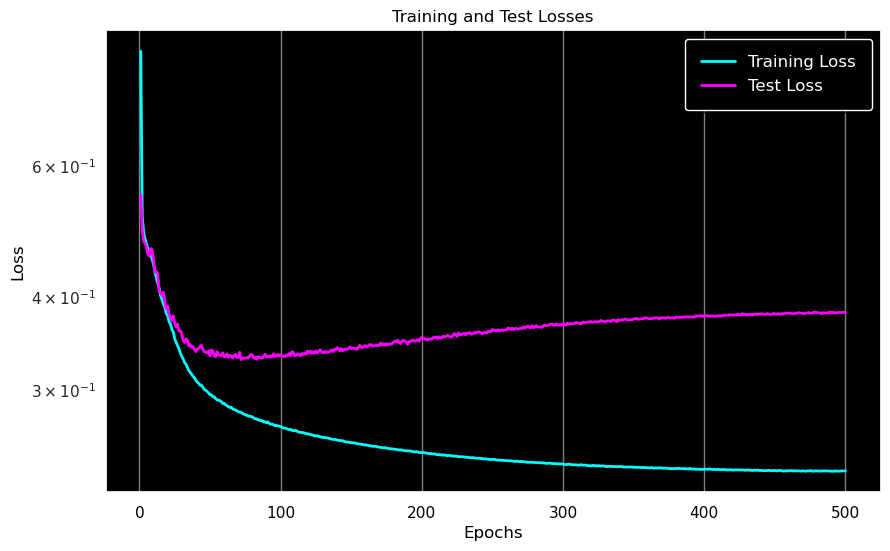

In [ ]:
"""
Plotting training and validation losses
"""
# Function to plot training and test losses with custom style
def plot_losses(train_losses, test_losses):
    sns.set(style='darkgrid', rc={"axes.facecolor": "black", "grid.color": "grey"})  # Setting the style
    plt.figure(figsize=(10, 6))
    
    epochs = np.arange(1, len(train_losses) + 1)  # Assuming train_losses and test_losses are of the same length
    
    plt.plot(epochs, train_losses, label='Training Loss', color='cyan', linewidth=2)  # Thicker line for Training Loss
    plt.plot(epochs, test_losses, label='Test Loss', color='magenta', linewidth=2)  # Thicker line for Test Loss
    
    plt.title('Training and Test Losses', color='black')
    plt.xlabel('Epochs', color='black')
    plt.ylabel('Loss', color='black')
    plt.yscale('log')  # Set y-axis to log scale
    
    plt.tick_params(axis='x', colors='black')  # Change tick color to white
    plt.tick_params(axis='y', colors='black')  # Change tick color to white
    
    plt.legend(facecolor='black', edgecolor='white', fontsize='medium', fancybox=True, framealpha=1, shadow=True, borderpad=1, labelcolor='white')
    plt.show()


# Make sure to call this function after the training loop
plot_losses(train_losses, test_losses)

